# Squeezed Lasing: symmetry-broken states ($\Omega$ variation)

In [63]:
import math as math
import numpy as np
import scipy as scipy
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import matplotlib.animation as animation
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import sys
import os

from qutip import *
from src_2_0 import *

In [64]:
def H_def(a,sigma,Delta_c,Delta_0,g,r,theta,omega=0,phi=0): # Defines the Hamiltonian of the system. It considers a coupling between a photonic cavity and a one-atom subsystem.
    return Delta_c*a.dag()*a+Delta_0*sigma.dag()*sigma+g*(sigma*(np.cosh(r)*a.dag()+np.exp(1j*theta)*np.sinh(r)*a)+sigma.dag()*(np.cosh(r)*a+np.exp(-1j*theta)*np.sinh(r)*a.dag()))+omega*(a*np.exp(-1j*phi)+a.dag()*np.exp(1j*phi))

In [65]:
def Lops_def(a,sigma,k,P,eta): # Defines the system's collapse (Lindblad) operators, one that represents incoherent pumping and other that describes photon loss.
    return [np.sqrt(P)*sigma.dag(),np.sqrt(k*(1+eta))*a]

#### Parameters

In [66]:
### General parameters ###

N = 200 # Dimension of the Hilbert space of the cavity
n_q = 100 # Photon saturation number
C = 1 # Cooperativity (equal to the pumping parameter p)
eta = 0 # Photon loss due to other decay channels

### Hamiltonian parameters ###

g_0 = 10**(-5.9) # Light-matter coupling
Delta = 1 # Detunings Delta_s = Delta_r
r = 0.75 # Squeezing parameter
theta = np.pi # Squeezing angle
Omega_r = 1e-2

### Symmetry broken parameters ###

omega = np.linspace(0,1e-7,25) # Amplitude of the coherent driving with well defined phase
phi = 0 # Fixed phase

#### Parameter-dependent quantities

In [67]:
k = g_0*np.sqrt(2/(C*n_q)) # Photon decay rate
P = 2*n_q*k # Incoherent pumping
g = g_0*np.cosh(r)
C_s = C*np.cosh(r)**2 # Squeezed cooperativity (equal to the squeezed pumping parameter p_s)

In [68]:
delta_c = (4*g**2*np.cosh(r)**2*Delta)/Omega_r**2 # Chosen like this so that Delta_c and Delta_0 are zero
Delta_1 = (Omega_r**2/(4*Delta))*(1-np.tanh(r)**2)

#### Operators

In [69]:
a = tensor(destroy(N),identity(2)) # Annihilation operator of the bare basis
a_s = a*np.cosh(r)+np.exp(-1j*theta)*a.dag()*np.sinh(r) # Annihilation operator of the squeezed basis
sigma = tensor(identity(N),basis(2,0)*basis(2,1).dag()) # Lowering operator of the two-level system
S = (0.5*(r*np.exp(-1j*theta)*a_s*a_s-np.conj(r*np.exp(-1j*theta))*a_s.dag()*a_s.dag())).expm() # Squeezing operator

#### Collapse operators

In [70]:
Lops = Lops_def(a,sigma,k,P,eta) # Iniatilize the collapse operators for the chosen parameters

#### Steady-states

In [71]:
rho_ss = [] # Steady states of the system

for i in tqdm(range(np.size(omega))):
     rho_ss.append(steadystate(H_def(a,sigma,0,0,g,r,theta,omega[i],phi),Lops)) # Calculate the density matrix of the steady states

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [40:43<00:00, 97.76s/it]


### 1. Coherent state selection in the squeezed basis

In [72]:
n_s = np.zeros(np.size(omega)) # Photon population in the squeezed basis
a_2 = np.zeros(np.size(omega)) # Reference to compare with coherent state

for i in tqdm(range(np.size(omega))):
    n_s[i] = expect(a_s.dag()*a_s,rho_ss[i]) # Calculate the photon population in the squeezed basis
    a_2[i] = np.abs(expect(a_s,rho_ss[i]))**2 # Calculate the square of the mean value of a_s

100%|██████████| 25/25 [00:00<00:00, 53.04it/s]


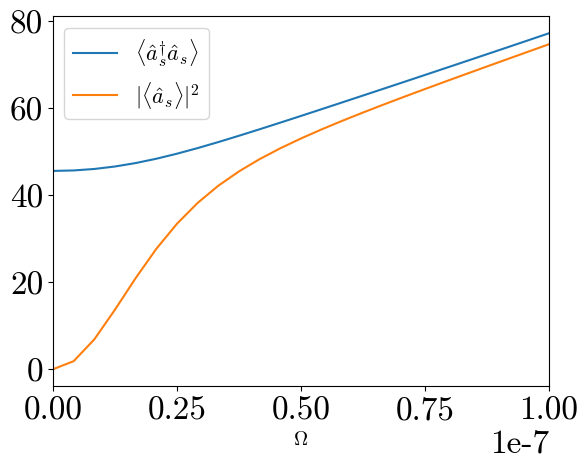

In [73]:
plt.plot(omega,n_s,label=r'$\langle \hat{a}_s^{\dag}\hat{a}_s \rangle$')
plt.plot(omega,a_2,label=r'$|\langle \hat{a}_s \rangle|^2$')
plt.xlim([np.min(omega),np.max(omega)])
#plt.ylim([0,n_q])
# plt.title('Photon number')',fontsize=14)
plt.xlabel('$\Omega$',fontsize=14)
plt.legend()

In [74]:
esp = np.column_stack([omega,n_s,a_2])
np.savetxt('.\SEC_V_B/OMEGA_VAR_'+str(format(phi,'.3f'))+'_'+str(format(C,'.1f'))+'_'+str(format(r,'.2f'))+'.txt',esp)

FileNotFoundError: [Errno 2] No such file or directory: '.\\SEC_V_B/OMEGA_VAR_0.000_1.0_0.75.txt'

### 2. Wigner distribution

In [102]:
index =  24 # Select the value of Omega by writing its index

In [99]:
omega[index]

8.333333333333334e-09

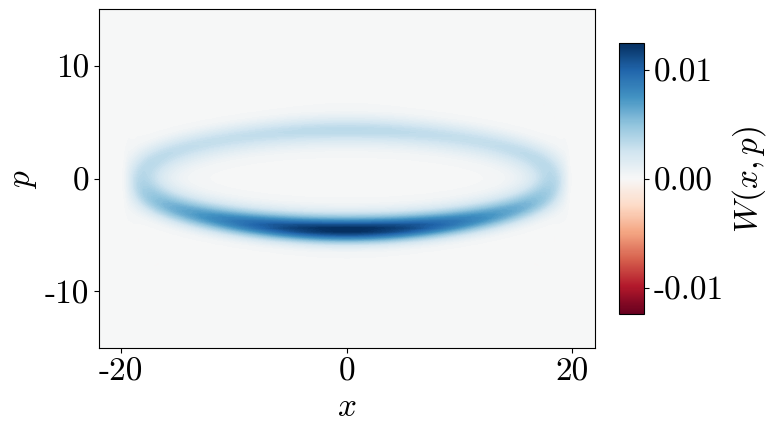

In [100]:
wr = wigner_rep(rhos = rho_ss[index]) # Initialize the calculation with its parameters
x_lim = 22 # X-Axis limits
p_lim = 15 # P-Axis limits
wr.wigner_plot(x_lim,p_lim) # Calculate the Wigner function

In [103]:
quad_ang = np.pi-(theta)/2 # Quadrature angle that specifies the field's quadrature to measure
X_ang = a*np.exp(-1j*quad_ang)+a.dag()*np.exp(1j*quad_ang) # Chosen quadrature operator
np.sqrt(expect(X_ang**2,rho_ss[index])-expect(X_ang,rho_ss[index])**2)

1.021622251111511

In [104]:
np.exp(-r)

0.4723665527410147

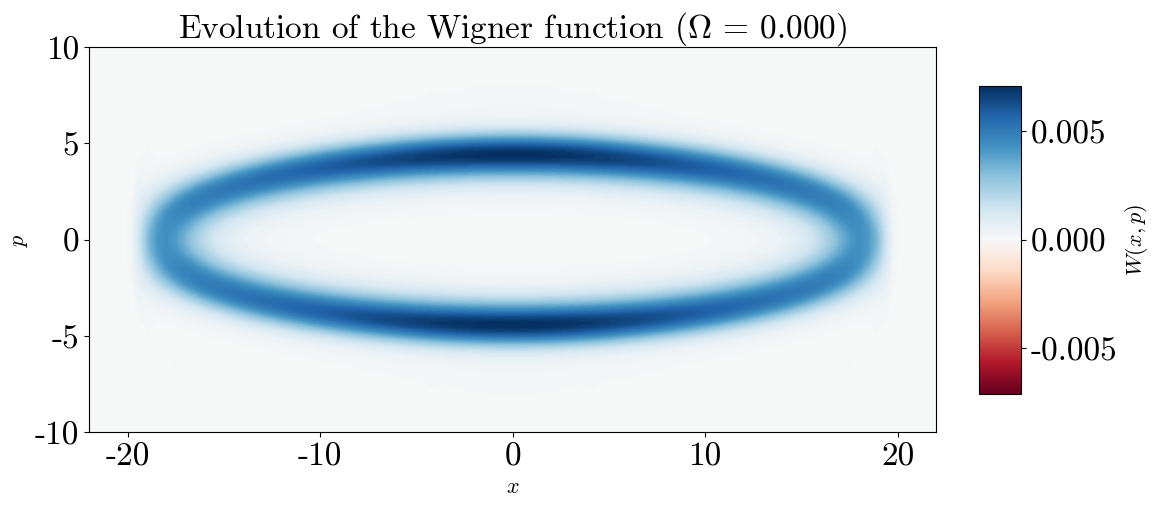

In [106]:
wigner_rep(rhos = rho_ss).wigner_animation(22,10,omega,figname = 'Heff_Var_OMEGA',speed = 100, mrname = r'$\Omega$') # Create an animation for the whole range of omega